# Machine Learning for Post-Processing NWM Data 
**Authors: Savalan Naser Neisary (PhD Student, CIROH & The University of Alabama)**




### 1. Introduction 
#### 1.1. Overview of the Workshop’s Goals and Structure.

This is going to be 90 minutes workshop in which we will:
- Introduce post-processing and its application in hydrology.
- Learn how to develop different types of decision tree models including Random Forest (RF) and Extreme Gradient Boosting (XGBoost). 
- Learn how to tune model hyperparameters. 
- Learn how to do the feature selection using decision-tree based algorithms. 
- Learn how to use Git and Amazon S3 buckets in our model development process. 

We will first go over the theoretical background behind the decision-trees and the pros and cons of the most powerful decision-tree algorithms. Then, we will start the hands-on part of the workshop and how we should set up our environments and how to get codes and data from GitHub repositories and Amazon S3 buckets. Next, we plan to get the data preprocess them, and start model development using different decision-tree algorithms. After that, we will talk about the feature selection and hyperparameter tuning (i.e., manually and automatically). Finally, we will evaluate the tree models and see compare them from different perspective in a real hydrology application. 
#### 1.2. Post-processing Hydrological Predictions

Effective and sustainable management of water resources is crucial to provide adequate water supply for human societies, regardless of their geographical location. Having an accurate and precise prediction of future hydrological variables, including streamflow is a critical component for an effective water systems management, and various studies presented different methods, such as post-processing to increase the accuracy of the hydrological predictions. Post-processing methods seek to quantify the uncertainties of hydrological model outcomes and correct their biases by using a statistical model to transform model outputs based the relationship(s) between observations and model. According to the literature Machine Learning (ML) models proved to be useful in post-processing the results of other ML or physical-based hydrological models. Therefore, in this workshop we will use decision-tree algorithms, an ensemble  subgroup of ML models, to post-process streamflow outputs of a physical-baed model. 
#### 1.3. Post-processing Retrospective National Water Model (NWM) Streamflow Data

NOAA introduced the NWM to address the need for an operational large-scale hydrological forecasting model to provide streamflow predictions in CONUS. While it has the capability of predicting streamflow in 2.7 billion water reaches, according to the literature, NWM has a low accuracy in regions west of the 95th meridian with drought and low-flow problem and in controlled basins with extensive water infrastructure. This low performance in western US watersheds is due to the lack of water operation consideration and a comprehensive groundwater and snow model beside calibrating NWM mostly with watersheds in eastern US. To compensate for NWM shortcomings in this workshop we will demonstrate how we can use decision-trees to increase its accuracy by post-processing the NWM outputs and adding the human activity impact to it.   

###### Recommended Resources:
- Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow.
- C4.5: Programs for Machine Learning.
- A Holistic Comparative Application of Artificial Intelligence Methods in Reservoir Inflow Forecast. 






### 2. Theoretical Background 

#### 2.1. Long Short Term Memory (LSTM)
Long Short-Term Memory networks, commonly known as LSTMs, are a special kind of recurrent neural network (RNN) capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber in 1997 and have since been a fundamental component in the progression of deep learning, particularly in sequences and time series data. LSTMs are designed to avoid the long-term dependency problem, allowing them to remember information for extended periods. This is crucial in tasks such as language translation, speech recognition, and time series forecasting where the context and past information significantly influence the current output.

LSTMs achieve this capability through a complex architecture that includes several gates: the input gate, the forget gate, and the output gate. Each gate in an LSTM cell regulates the flow of information, deciding what to retain and what to discard, thus effectively maintaining the cell state across time steps. The gates are composed of sigmoid neural net layers that output numbers between zero and one, describing how much of each component should be let through. This gating mechanism differentiates LSTMs from other neural networks by giving them finer control over the gradient flow and state updates, which helps in maintaining stable gradients over time, thereby making them highly effective for tasks involving sequential data.

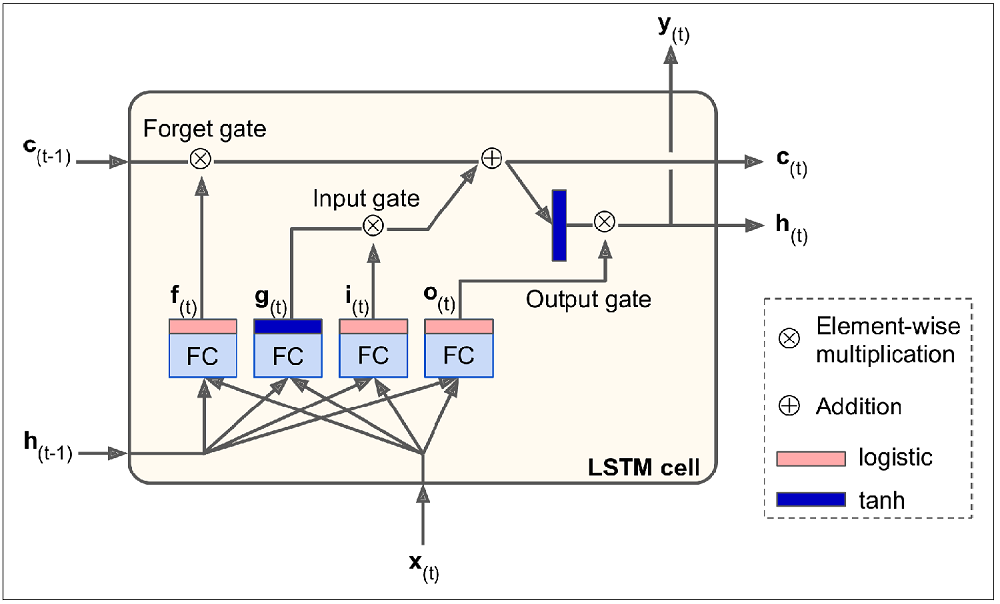


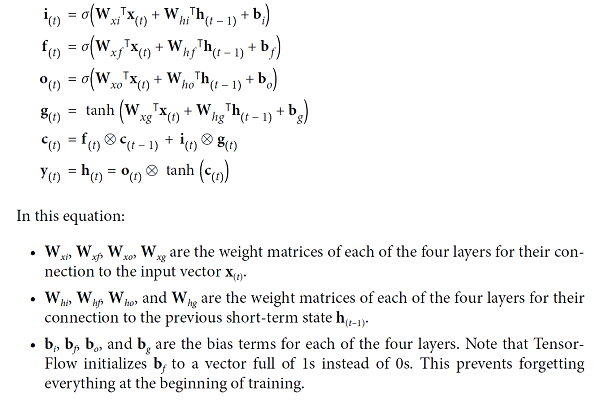


## 3. Setting Up the Environment 

#### 3.1. Setup and Verification of the Environment
After logging into the CIROH 2i2c cloud you will have to do take three steps before being ready for developing the model:
- Installing the required Python libraries using Conda environment manager. 
- Getting the codes using Git and GitHub.
- Getting the data from Amazon S3 buckets. 

For the first step, as mentioned we will use conda to create a new virtual environment, install the packages, and install the Jupyter notebook kernel. We need to create a virtual environment for each project since different projects would use different version of packages, otherwise each time we install a new package for a new project we will have errors related to version conflicts. Conda is a tool that creates these environments and checks for the best version of each package which is compatible with the rest of the packages. After opening a terminal we will take the following steps to set up the environment:

#### 3.2. Access the GitHub Codes
The next step is to download the code files from the GitHub. In the terminal you should use the following command:

#### 3.3. Import the Python Libraries
Nest we will import the libraries that we need. 

In [1]:
# my packages
from evalaution_table import EvalTable
from figure_generator import EvalPlot

# basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import joblib

# system packages
from progressbar import ProgressBar
from datetime import datetime, date, timedelta
import pickle
import warnings
warnings.filterwarnings("ignore")
import platform
import time
from tqdm import tqdm
import os
import boto3
from botocore.client import Config
from botocore import UNSIGNED

# hydrological packages
import hydroeval as he
from hydrotools.nwm_client import utils # I had to pip install this

# data analysis packages
from scipy import optimize
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# deep learning packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Identify the path
home = os.getcwd()
parent_path = os.path.dirname(home)
input_path = f'{parent_path}/02.input/'
output_path = f'{parent_path}/03.output/'
main_path = home

#### 3.4. Access the Data on Amazon S3 Bucket
To get the data from S3 buckets you will use the *boto3* package that we downloaded. To use this package we do not need the terminal anymore, so now we will open the *01.tutorial_post_processing.ipynb* from the left hand side and click on the *3.3. Access the Data on Amazon S3 Bucket* in the table of contents to come to this line. For the rest of the tutorial we will use this notebook. 

In [2]:
#load access key
home = os.path.expanduser('~')
keypath = "aws_key.csv"
access = pd.read_csv(f"{home}/{keypath}")

#start session
session = boto3.Session(
    aws_access_key_id=access['Access key ID'][0],
    aws_secret_access_key=access['Secret access key'][0])
bucket_name = 'streamflow-app-data'
s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
bucket = s3.Bucket(bucket_name)


## 4. Data Preprocessing
#### 4.1. Overview of the USGS Stream Station
- The dataset that we will use provides the data for 10155000 station in Weber watershed, and its NHDPlus id is 10375648. 
- This station is below #### reservoir and was effected by reservoir operation. 
- The dataset contains climate variables, such as precipitation and temperature, water infrastructure, including storage percentage, and watershed characteristics, such as average area and elevation. 
You can see the location of the station and its watershed in the Figure below. 

#### 4.2. Load Dataset

In [3]:
# List of station IDs that are of interest.
stations = ['10126000', '10130500', '10134500', '10136500', '10137500', '10141000', '10155000', '10164500', '10171000']

# Read a CSV file into a DataFrame and set the first column as the index.
df = df = pd.read_parquet(f'{input_path}final_input.parquet')

# Convert the station_id column to string data type.
df.station_id = df.station_id.astype(str)

# Convert the 'datetime' column to datetime objects.
df.datetime = pd.to_datetime(df.datetime)

# Filter the DataFrame to include only the rows where 'station_id' is in the 'stations' list.
df_modified = df[df['station_id'].isin(stations)]

# Select specific columns to create a new DataFrame.
dataset = df_modified[['station_id', 'datetime', 'Lat', 'Long', 'Drainage_area_mi2', 'Mean_Basin_Elev_ft',
       'Perc_Forest', 'Perc_Develop', 'Perc_Imperv', 'Perc_Herbace',
       'Perc_Slop_30', 'Mean_Ann_Precip_in', 's1',
       's2', 'storage', 'swe', 'NWM_flow', 'DOY','tempe(F)', 'precip(mm)', 'flow_cfs']]

# Extract a list of unique station IDs from the modified dataset.
station_list = dataset.station_id.unique()


#### 4.3. Visualizing the Data
- The takeaway from data visualization is to gather information about data distribution, outliers, missing values, correlation between different variables, and time dependencies between variables.
- Here, we will use boxplots, histograms, and combo bar and line plots to show outliers, distribution, and time dependencies in streamflow, precipitation, temperature, and SWE.

First, we will plot the time dependencies using bar and line plots for streamflow vs precipitation and SWE. 

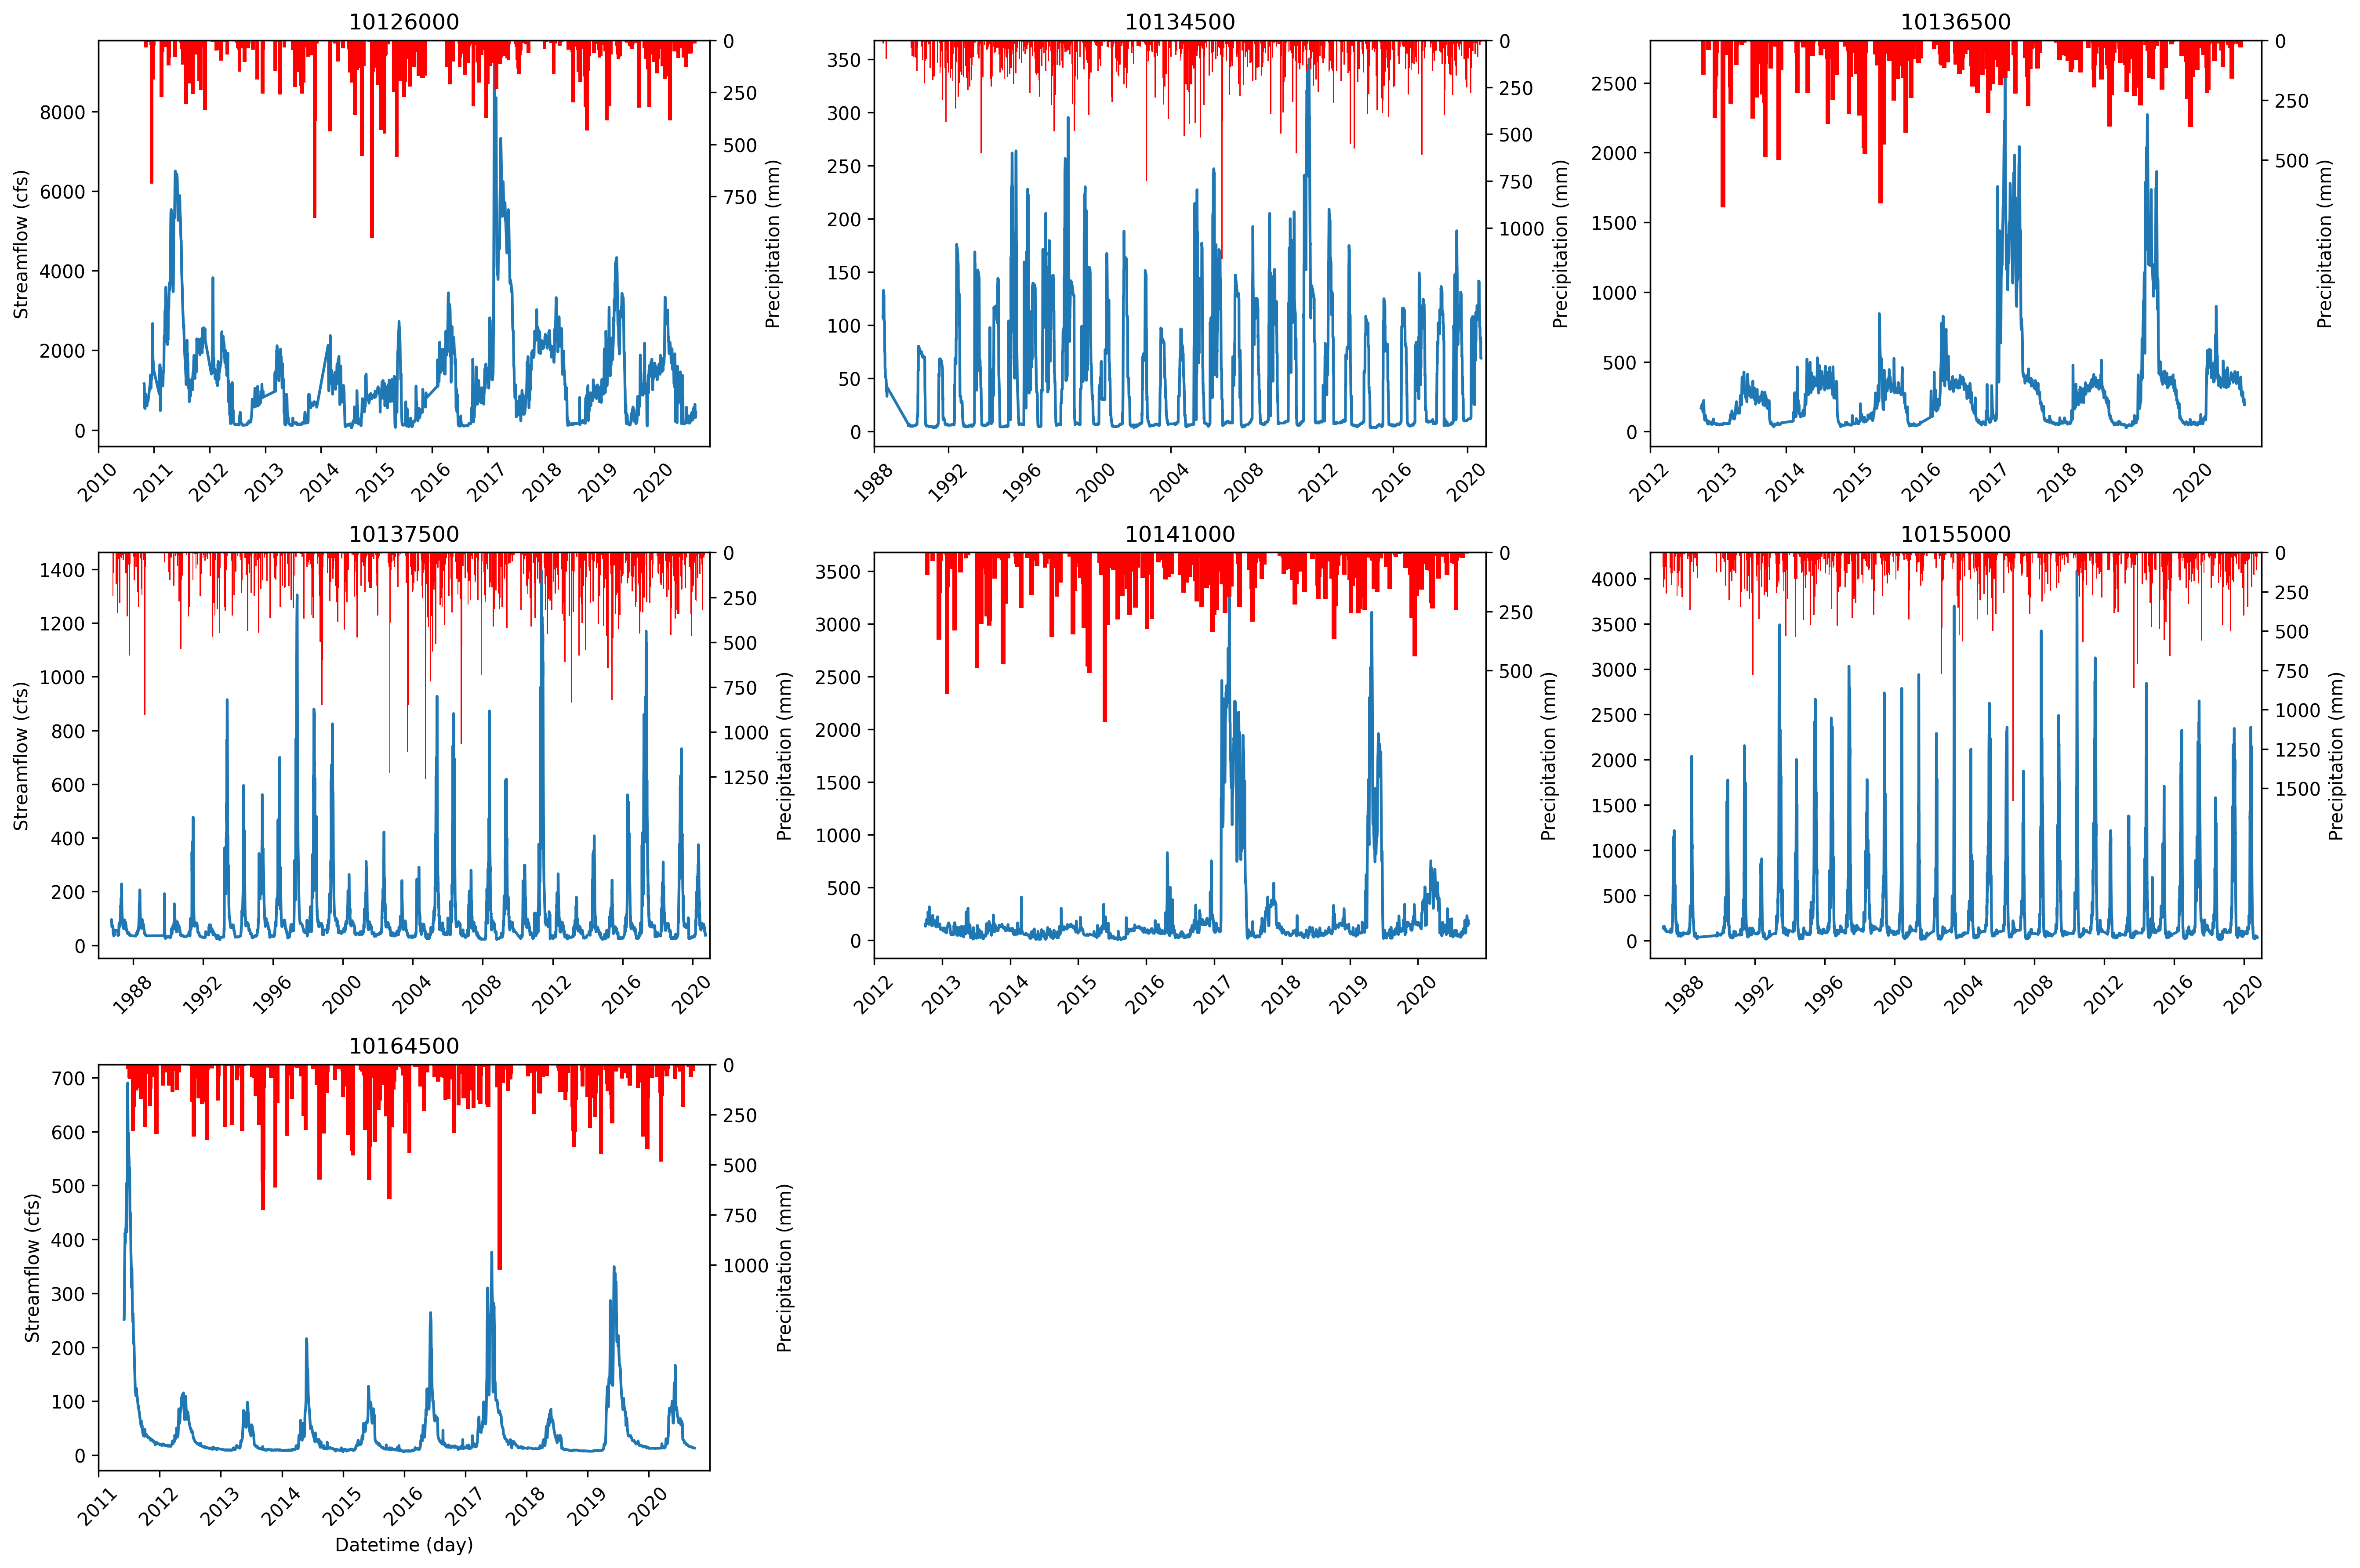

CPU times: user 33.3 s, sys: 671 ms, total: 34 s
Wall time: 34.1 s


In [4]:
%%time
# Calculate the number of subplots needed based on the number of unique stations.
n_subplots = len(station_list)
# Determine the number of columns in the subplot grid by taking the ceiling of the square root of 'n_subplots'.
n_cols = int(math.ceil(math.sqrt(n_subplots)))
# Determine the number of rows in the subplot grid by dividing 'n_subplots' by 'n_cols' and taking the ceiling of that.
n_rows = int(math.ceil(n_subplots / n_cols))
# Set the figure size for the subplots.
figsize = (18, 12)
# Create a grid of subplots with specified number of rows and columns and figure size.
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, dpi=300)
# Flatten the axes array for easier iteration.
axes = axes.flatten()

# Iterate over the axes to plot the data for each station.
for i, ax in enumerate(axes):
    if i < n_subplots:
        # Extract the data for the current station from the dataset.
        temp_df_1 = dataset[dataset.station_id == station_list[i]]
        # Set 'datetime' as the index for plotting.
        temp_df_2 = temp_df_1.set_index('datetime')
        # Plot the 'flow_cfs' data on the primary y-axis.
        ax.plot(temp_df_2.index, temp_df_2['flow_cfs'])
        # Set the x-axis limits from the first to the last year of data.
        start_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.min()}-01-01')
        end_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.max()}-12-31')
        ax.set_xlim(start_year, end_year)
        # Rotate x-axis labels for better readability.
        labels = ax.get_xticklabels()
        ax.set_xticklabels(labels, rotation=45)

        # Create a second y-axis for the precipitation data.
        ax2 = ax.twinx()
        # Plot the 'precip(mm)' data as a bar graph on the secondary y-axis.
        ax2.bar(temp_df_2.index, temp_df_2['precip(mm)'], label='Inverted', color='red', width=25)
        # Set the y-axis limits for precipitation, flipping the axis to make bars grow downward.
        ax2.set_ylim(max(temp_df_2['precip(mm)']) + 1000, 0)
        # Set the label for the secondary y-axis.
        ax2.set_ylabel('Precipitation (mm)')
        # Define custom ticks for the secondary y-axis.
        ax2.set_yticks(np.arange(0, max(temp_df_2['precip(mm)']), 250))

        # Set the title of the subplot to the station ID.
        ax.set_title(f'{station_list[i]}')
        # Set the x-axis label for subplots in the last row.
        if i // n_cols == n_rows - 1:
            ax.set_xlabel('Datetime (day)')

        # Set the y-axis label for subplots in the first column.
        if i % n_cols == 0:
            ax.set_ylabel('Streamflow (cfs)')
    else:
        # Hide any unused axes.
        ax.axis('off')

# Adjust layout to prevent overlapping elements.
plt.tight_layout()
# Uncomment the line below to save the figure to a file.
# plt.savefig(f'{save_path}scatter_annual_drought_number.png')
# Display the plot.
plt.show()


The next plot shows SWE vs streamflow. 

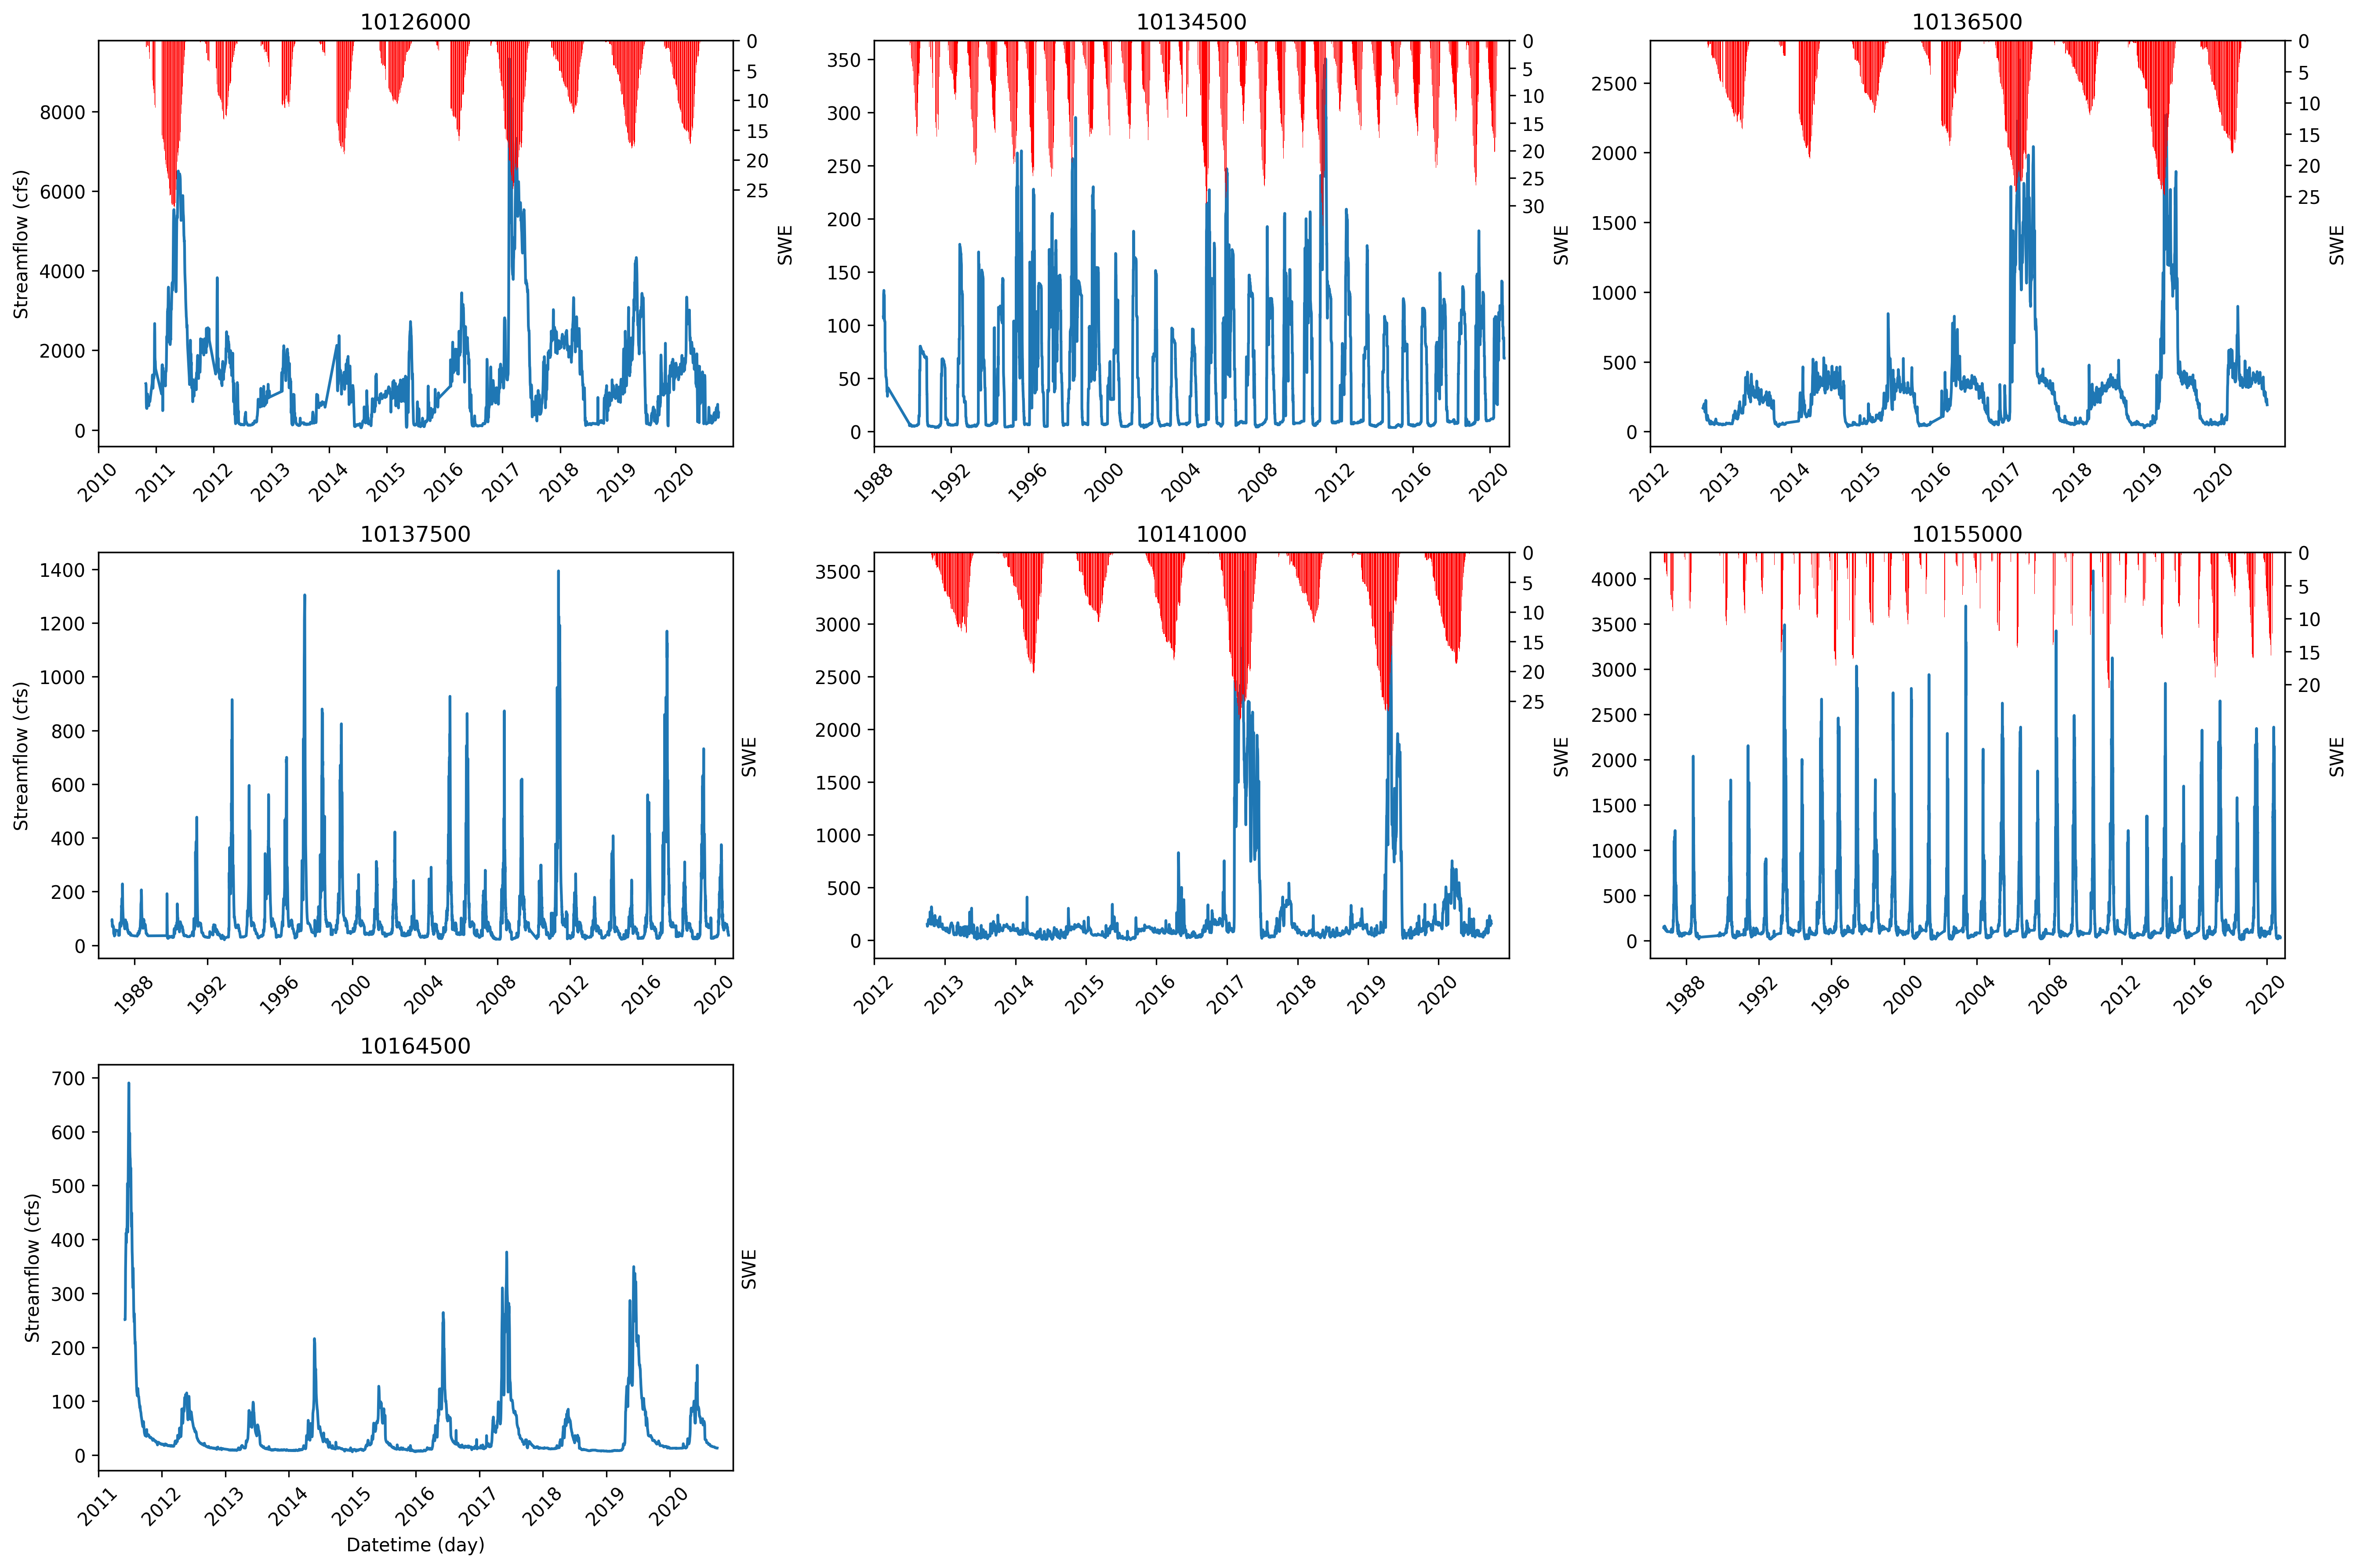

CPU times: user 34.4 s, sys: 535 ms, total: 34.9 s
Wall time: 35 s


In [5]:
%%time
# Initialize variables for the number of plots, columns, and rows based on the number of unique stations.
n_subplots = len(station_list)
n_cols = int(math.ceil(math.sqrt(n_subplots)))  # Calculate columns as the ceiling of the square root of number of subplots.
n_rows = int(math.ceil(n_subplots / n_cols))  # Calculate rows as the ceiling of the ratio of subplots to columns.
figsize = (18, 12)  # Set the figure size for the plot.
# Create a figure and a grid of subplots with the specified number of rows and columns.
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, dpi=300)
axes = axes.flatten()  # Flatten the axes array for easier iteration.

# Iterate over each axis to plot data for each station.
for i, ax in enumerate(axes):
    if i < n_subplots:  # Check if the current index is less than the number of subplots to populate.
        # Extract data for the current station.
        temp_df_1 = dataset[dataset.station_id == station_list[i]]
        # Set 'datetime' as the index for the DataFrame for plotting.
        temp_df_2 = temp_df_1.set_index('datetime')
        # Plot 'flow_cfs' on the primary y-axis.
        ax.plot(temp_df_2.index, temp_df_2['flow_cfs'])
        # Set x-axis limits from the minimum to maximum year of data.
        start_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.min()}-01-01')
        end_year = pd.to_datetime(f'{temp_df_1.datetime.dt.year.max()}-12-31')
        ax.set_xlim(start_year, end_year)
        # Get current x-tick labels and set their rotation for better visibility.
        labels = ax.get_xticklabels()
        ax.set_xticklabels(labels, rotation=45)

        # Create a secondary y-axis for Snow Water Equivalent (SWE).
        ax2 = ax.twinx()
        # Plot SWE as a bar graph on the secondary y-axis.
        ax2.bar(temp_df_2.index, temp_df_2['swe'], label='Inverted', color='red')
        # Set the y-axis limits for SWE, flipping the axis to make bars grow downward.
        ax2.set_ylim(max(temp_df_2['swe']) + 40, 0)
        # Set label for the secondary y-axis.
        ax2.set_ylabel('SWE')
        # Define custom ticks for the secondary y-axis.
        ax2.set_yticks(np.arange(0, max(temp_df_2['swe']), 5))

        # Set the title of the subplot to the station ID.
        ax.set_title(f'{station_list[i]}')
        # Set the x-axis label for subplots in the last row.
        if i // n_cols == n_rows - 1:
            ax.set_xlabel('Datetime (day)')

        # Set the y-axis label for subplots in the first column.
        if i % n_cols == 0:
            ax.set_ylabel('Streamflow (cfs)')
    else:
        # Hide any unused axes.
        ax.axis('off')

# Adjust the layout to prevent overlapping elements.
plt.tight_layout()
# Uncomment the line below to save the figure to a file.
# plt.savefig(f'{save_path}scatter_annual_drought_number.png')
# Display the plot.
plt.show()


Next, we will use histograms for streamflow to see its skewness and distribution. 

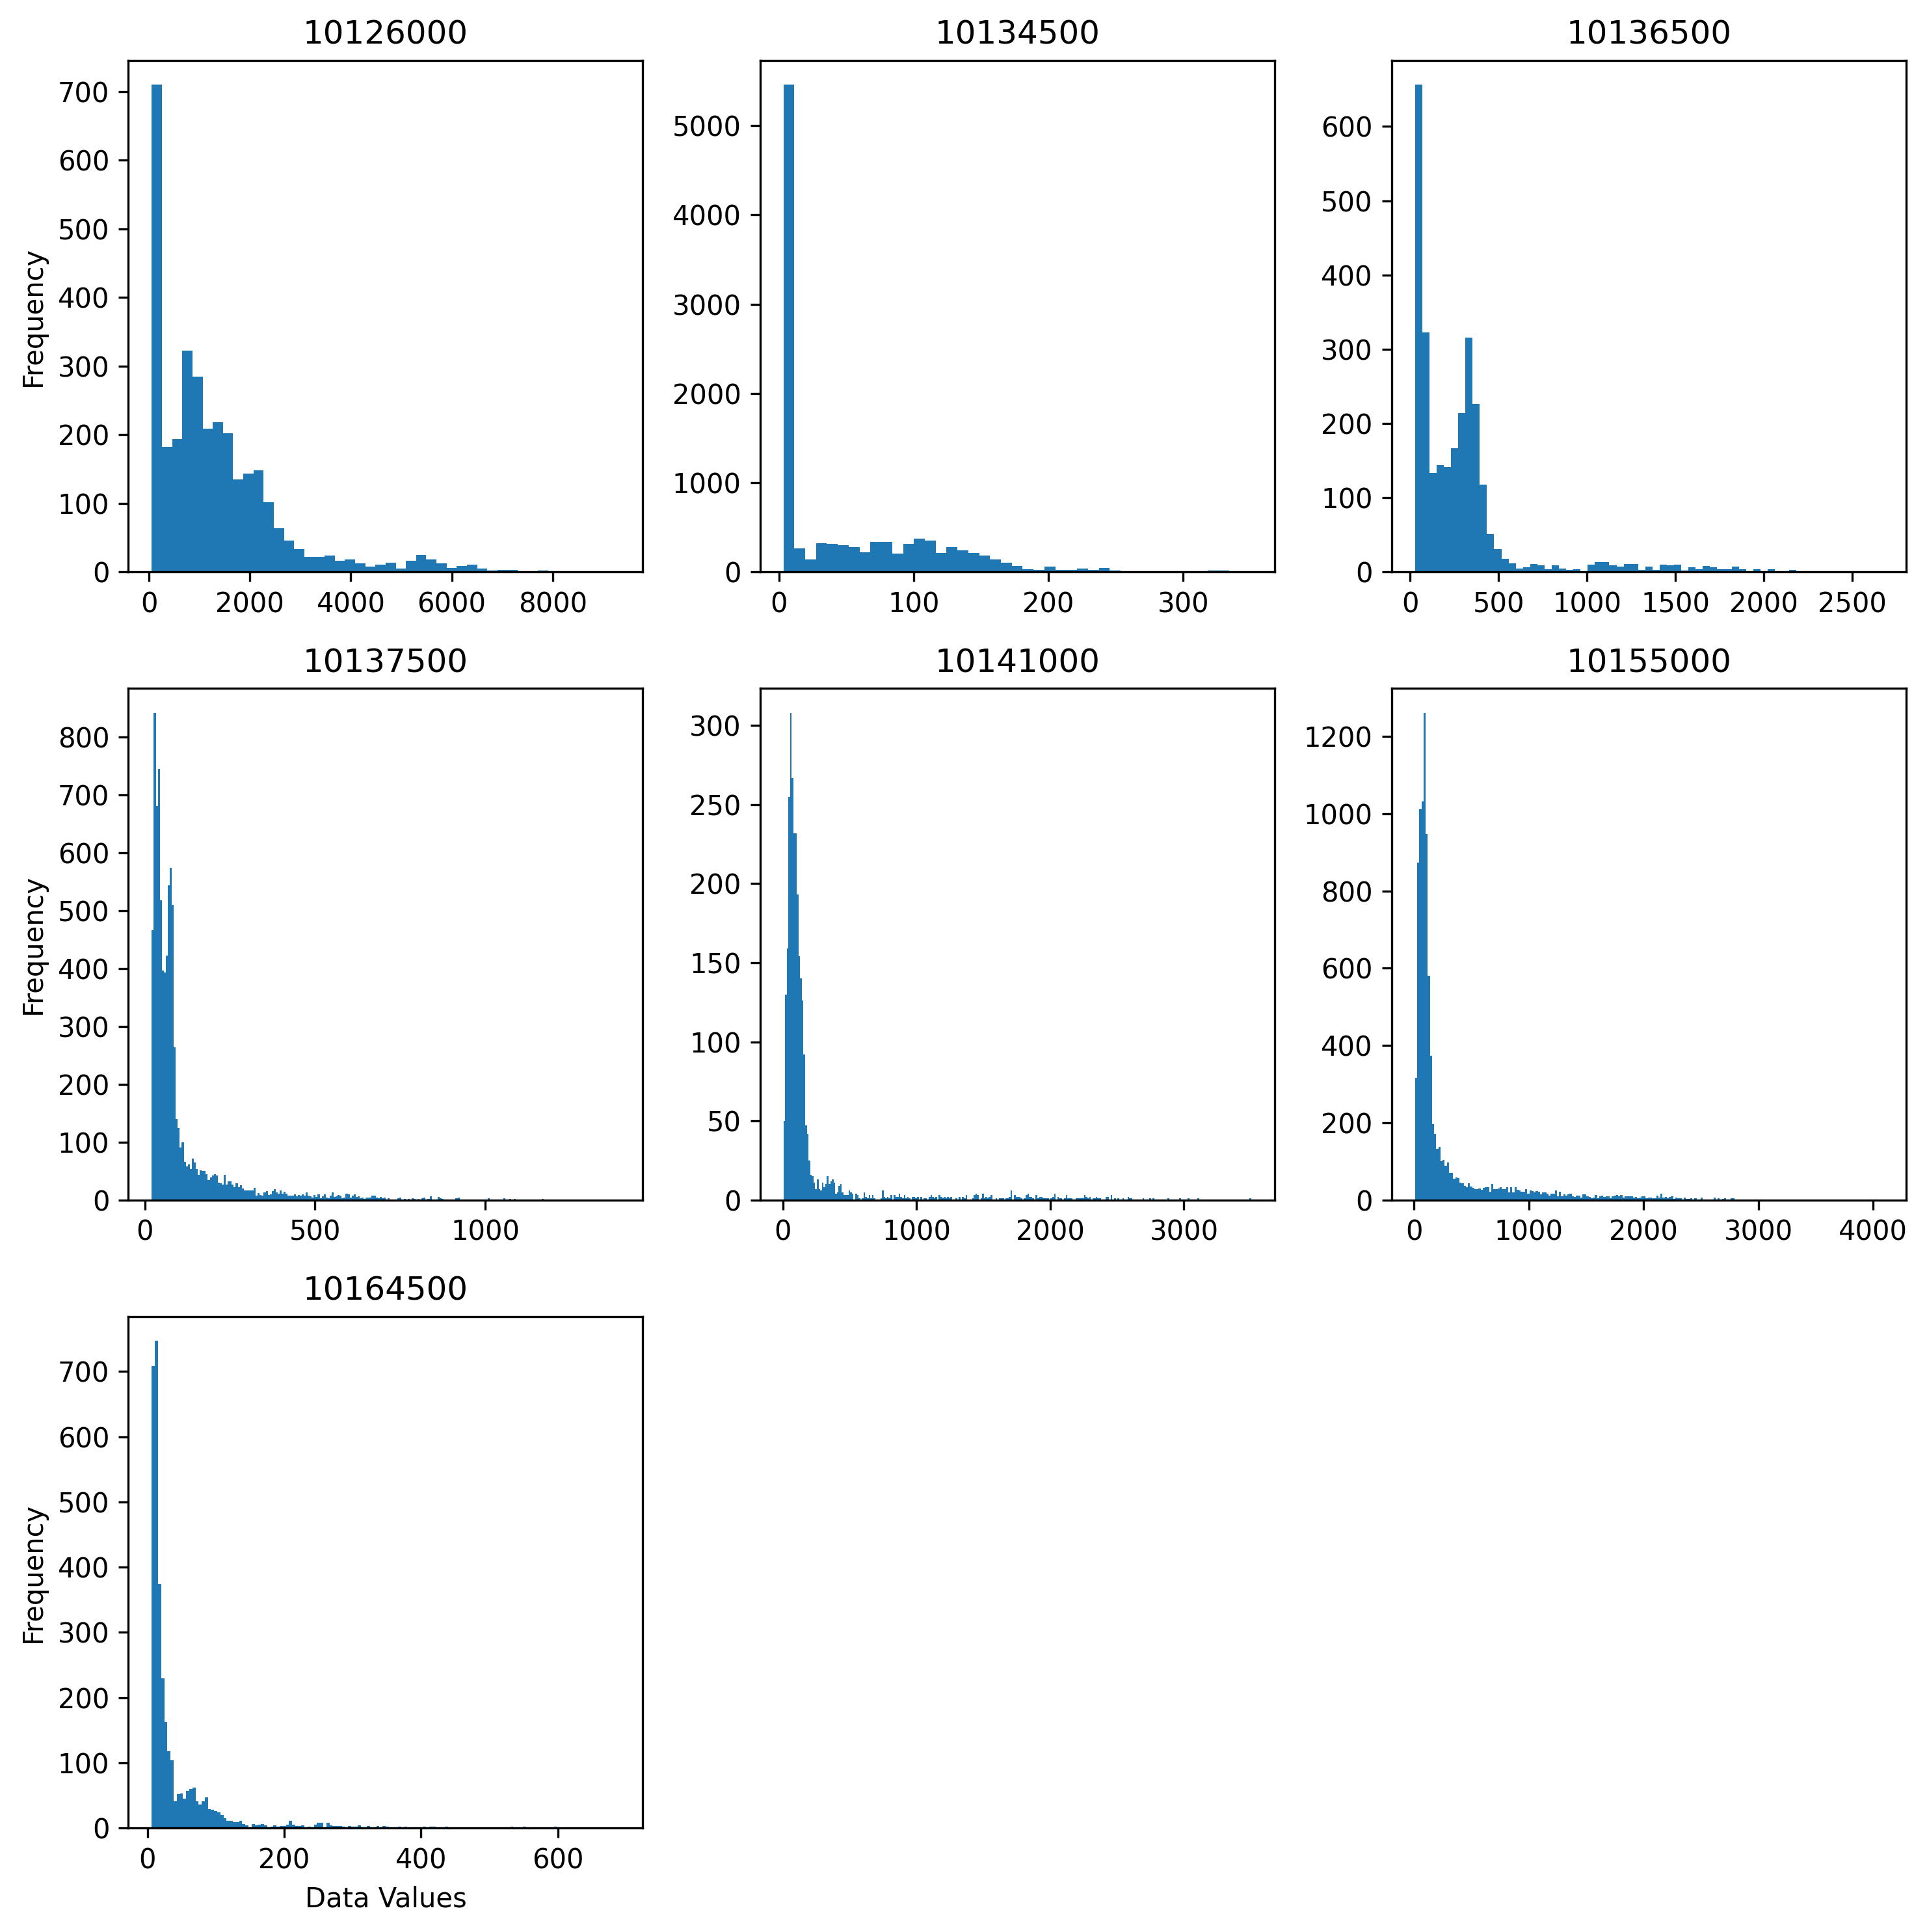

CPU times: user 1.73 s, sys: 66.7 ms, total: 1.79 s
Wall time: 1.79 s


In [6]:
%%time
# Determine the number of subplots based on the number of unique stations.
n_subplots = len(station_list)
# Calculate the number of columns for subplots based on the square root of the number of subplots.
n_cols = int(math.ceil(math.sqrt(n_subplots)))
# Calculate the number of rows for subplots based on the total subplots and columns.
n_rows = int(math.ceil(n_subplots / n_cols))
# Set the size of the figure for subplots.
figsize = (10, 10)
# Create a figure and a grid of subplots with the specified rows and columns, and figure size.
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, dpi=300)
axes = axes.flatten()  # Flatten the axes array for easier access in looping.

# Loop through each axis to plot histogram for each station.
for i, ax in enumerate(axes):
    if i < n_subplots:
        # Extract the data for the current station.
        temp_df_1 = dataset[dataset.station_id == station_list[i]]

        # Calculate the Interquartile Range (IQR) for the 'flow_cfs' data.
        IQR = np.percentile(temp_df_1['flow_cfs'], 75) - np.percentile(temp_df_1['flow_cfs'], 25)
        # Calculate the bin width using Freedman-Diaconis rule which is optimal for histogram.
        bin_width = 2 * IQR * (len(temp_df_1['flow_cfs']) ** (-1/3))
        # Calculate the number of bins for the histogram using the calculated bin width.
        bins_fd = int((max(temp_df_1['flow_cfs']) - min(temp_df_1['flow_cfs'])) / bin_width)

        # Plot a histogram of 'flow_cfs' for the station with calculated bins.
        ax.hist(temp_df_1['flow_cfs'], bins=bins_fd)

        # Set the title of the subplot to the station ID.
        ax.set_title(f'{station_list[i]}')
        # Set the x-axis label for subplots in the last row.
        if i // n_cols == n_rows - 1:
            ax.set_xlabel('Data Values')

        # Set the y-axis label for subplots in the first column.
        if i % n_cols == 0:
            ax.set_ylabel('Frequency')
    else:
        # Hide unused subplots.
        ax.axis('off')

# Adjust the layout to prevent overlapping elements.
plt.tight_layout()
# Uncomment the line below to save the figure to a file.
# plt.savefig(f'{save_path}scatter_annual_drought_number.png')
# Display the plot.
plt.show()


#### 4.4. Splitting the Data
We split 80 percent of the data for trainging and the rest for testing the model, but we do not shuffele the data since LSTM needs to get the data in the right temporal sequence to understand the temporal relationships. So we will split the data based on the dates, 1986-2014 (80%) training and 2014-2020 (20%) testing. 
 


In [7]:
# Create empty DataFrames for training and testing datasets.
data_train = pd.DataFrame()
data_test = pd.DataFrame()

# Loop through each station name in the list of station IDs.
for station_name in station_list:
    # Extract data for the current station and reset the index.
    temp_df_1 = dataset[dataset.station_id == station_name].reset_index(drop=True)
    
    # Determine the maximum and minimum years in the dataset for the current station.
    end_year = temp_df_1.datetime.dt.year.max()
    start_year = temp_df_1.datetime.dt.year.min()
    
    # Calculate the duration in years between the earliest and latest data points.
    duration = end_year - start_year
    
    # Calculate the division year to split training and testing data (80% for training).
    division_year = start_year + int(duration * 0.8)
    
    # Select data from the start year up to the division year for training, reset the index, and append to the training DataFrame.
    data_train = pd.concat((data_train.reset_index(drop=True), temp_df_1[temp_df_1.datetime < f'{division_year}-01-01'].reset_index(drop=True)), axis=0).reset_index(drop=True)
    
    # Select data from the division year onward for testing, reset the index, and append to the testing DataFrame.
    data_test = pd.concat((data_test.reset_index(drop=True), temp_df_1[temp_df_1.datetime >= f'{division_year}-01-01'].reset_index(drop=True)), axis=0).reset_index(drop=True)


#### 4.5. Scaling the Data
To use Neural Network models, such as LSTM we need to scale the data between zero and one since the scale of data for each feature can be very different than the other ones. Different scales hinders the model from learning. There are several functions for scaling or you can even create your own function, but for this tutoral we will use the famous MinMax() function from Sklearn library. 



In [8]:
# Function for scaling the data. 
def input_scale(x_train, y_train):

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_train_scaled, y_train_scaled = \
    scaler_x.fit_transform(x_train), scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    return x_train_scaled, y_train_scaled, scaler_x, scaler_y

In [9]:
scaler_x = {}
scaler_y = {}
data_input_2 = {}


# Loop through each station name in the list of station IDs.

for variable_name in ['train', 'test']:
    if variable_name == 'train':
        temp_df_1 = data_train
    elif variable_name == 'test':
        temp_df_1 = data_test
    scaler_x[variable_name] = {}
    scaler_y[variable_name] = {}
    data_input_2[variable_name] = {}
    data_input_2[variable_name]['x'] = {}
    data_input_2[variable_name]['y'] = {}
    data_input_2[variable_name]['scaler_x'] = {}
    data_input_2[variable_name]['scaler_y'] = {}
    for station_name in station_list:
        # Extract data for the current station and reset the index.
        temp_df_2 = temp_df_1[temp_df_1.station_id == station_name].reset_index(drop=True)
        temp_output = input_scale(temp_df_2.iloc[:, 2:-1], temp_df_2.iloc[:, -1])
        data_input_2[variable_name]['x'][station_name] = temp_output[0]
        data_input_2[variable_name]['y'][station_name] = temp_output[1]
        data_input_2[variable_name]['scaler_x'][station_name] = temp_output[2]
        data_input_2[variable_name]['scaler_y'][station_name] = temp_output[3]
        joblib.dump(temp_output[2], f'{output_path}{variable_name}_{station_name}_scaler_x.joblib')
        joblib.dump(temp_output[3], f'{output_path}{variable_name}_{station_name}_scaler_y.joblib')
        
        

In [10]:
# scaler_x = MinMaxScaler()
# scaler_y = MinMaxScaler()
# data_train_scaled = data_train.copy()
# data_test_scaled = data_test.copy()
# data_train_scaled.iloc[:, 2:-1], data_train_scaled.iloc[:, -1] = \
# scaler_x.fit_transform(data_train.iloc[:, 2:-1]), scaler_y.fit_transform(data_train.iloc[:, -1].values.reshape(-1, 1))

# data_test_scaled.iloc[:, 2:-1], data_test_scaled.iloc[:, -1] = \
# scaler_x.transform(data_test.iloc[:, 2:-1]), scaler_y.transform(data_test.iloc[:, -1].values.reshape(-1, 1))

#### 4.6. Adding lookbacks 
- LSTM needs data from previous time steps with lag to capture the temporal relationship in the data. So we add the data with lag to our dataset and call it lookbacks. 
- A time series of n timesteps can produce approximately n lookbacks (e.g., a window can start at any time step given the lookbacks does not exceed the boundaries of the time series).
- Since we are using Pytorch we need to convert our data to Tensors with three dimensions. The first dimension will show us the batch size, number of the lookbacks will be the second dimension, and the third column will show the number of features. 
- For example, if our batc size is 100 with three features and four step lookbacks, the Tensor of input data would have (100, 4, 3) dimension. The four step lookbacks means, if our goal is to predict t+1 step the model would use the data from t, t-1, t-2, and t-3 time steps. 
- Druing adding the lookbacks we will also seperate the features and target datasets.  

In [11]:
def add_lookback(daya_x_input, data_y_input, length_lookback):
    data_x = []
    data_y = []
    for i in range(len(daya_x_input)-length_lookback):
        features, targets = daya_x_input[i:i+lookback, :-1], data_y_input[i+lookback:i+lookback+1, -1]
        data_x.append(features)
        data_y.append(targets)
    return np.array(data_x), np.array(data_y)


In [12]:
lookback = 2
data_input_final = {}


# Loop through each station name in the list of station IDs.

for variable_name in ['train', 'test']:
    data_input_final[variable_name] = {}
    data_input_final[variable_name]['x'] = {}
    data_input_final[variable_name]['y'] = {}
    for station_name in station_list:

        data_input_final[variable_name]['x'][station_name], data_input_final[variable_name]['y'][station_name] = \
        add_lookback(data_input_2[variable_name]['x'][station_name], data_input_2[variable_name]['y'][station_name], lookback) 
        


## 5. Model Development 
#### 5.1. Defining the Model
- As mentioned, we will use a Bidirectional LSTM model which has a simple two layer architecture and Pytorch library. 
- The first layer in our model is a bidirecional LSTM layer which is similar to normal LSTM and the only difference is that you have to turn 'bidirectional' variable to 'True' in the layer variables. 
- The second layer is fully connected layer which will get the ouptuts of LSTM layer, so we should multiple the neurans number (hidden_size variable) by two. 


In [13]:
# This file created on 01/13/2024 by savalan

# Import packages ==============================
# main packages
import torch
import torch.nn as nn
import torch.optim as optim

# Functions ==============================

class CustomBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, device=None):
        super(CustomBiLSTM, self).__init__()
        # Bidirectional LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Output size is doubled for bidirectional LSTM

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.loss_function = nn.L1Loss()
        self.device = device
        self.to(self.device)
        self.validation_indicator = 0

    def forward(self, x):
        # Initialize hidden state and cell state for both directions
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)  # 2 for bidirection
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)  # 2 for bidirection

        # Forward propagate LSTM
        # print(x.shape)
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

    def train_model(self, train_loader, epochs, optimizer, early_stopping_patience=0, val_loader=None, tune='False'):
        best_val_loss = float('inf')
        epochs_no_improve = 0


        for epoch in range(epochs):
            self.train()  # Set the model to training mode
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                optimizer.zero_grad()
                outputs = self.forward(inputs)
                loss = self.loss_function(outputs, targets)
                loss.backward()
                optimizer.step()

            
            val_loss = 0
            best_model_parameters = self.state_dict()
            if val_loader is not None:
                self.validation_indicator = 1
                val_loss = self.evaluate_model(val_loader)[1]

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_parameters = self.state_dict()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if epochs_no_improve == early_stopping_patience and early_stopping_patience > 0:
                    print('Early stopping triggered')
                    break
            if tune == 'False':
                print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss.item()}', f'Validation Loss: {val_loss}')
        self.validation_indicator = 0
        return best_model_parameters
        print('Training is done!')

    def evaluate_model(self, data_loader):
        self.eval()  # Set the model to evaluation mode
        total_loss = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                outputs = self.forward(inputs)
                loss = self.loss_function(outputs, targets)
                total_loss += loss.item() * inputs.size(0)
                total += inputs.size(0)
        avg_loss = total_loss / total
        # if self.validation_indicator == 0:
        #     # print(f'Validation Loss: {avg_loss}')
        return outputs, avg_loss
        #outputs if self.validation_indicator == 0 else avg_loss

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    def load_model(self, file_path):
        self.load_state_dict(torch.load(file_path, map_location=self.device))
# early stop and checkpoint shoudl be different functions. 

In [14]:
# Move the model and data to GPU. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


#### 5.2. Tuning the Hyperparameters
- We have several hyperparameters for our LSTM model, which we have to tune so that we can have the best possible results. 
- The tunning process can be done manually or by using optimization algorithms, in this tutorial we will use the values that we have identified to work best. 

In [38]:
# station_list ['10126000', '10134500', '10136500', '10137500', '10141000', '10155000', '10164500']
selected_station = '10126000'
epochs = 100 # We don't change it.
input_size = data_input_final['train']['x'][selected_station].shape[2]

In [39]:
# Feed the data to DataLoader and TensorDataset Functions
x_train_tensor = torch.Tensor(data_input_final['train']['x'][selected_station].astype(float))
y_train_tensor = torch.Tensor(data_input_final['train']['y'][selected_station].astype(float))
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

In [40]:
%%time

def tune_model(input_size, device, train_dataset, epochs, params):

    
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    # Create the Model
    bilstm_model = CustomBiLSTM(input_size, hidden_size, num_layers, 1, device)
    
    # Create the Optimizer
    bilstm_optimizer = optim.Adam(bilstm_model.parameters(), lr=learning_rate, weight_decay=0)
    
    # Run the training function
    model_parameters = bilstm_model.train_model(train_loader, epochs, bilstm_optimizer, early_stopping_patience=0, val_loader=None, tune='True')
    
    _, val_loss = bilstm_model.evaluate_model(train_loader)

    return val_loss, bilstm_model


CPU times: user 331 µs, sys: 7 µs, total: 338 µs
Wall time: 37.7 µs


In [41]:
# Define the initial parameters for the XGBoost model.
params = {
    'batch_size': 50,
    'learning_rate': 1e-4,
    'hidden_size': 300,
    'num_layers': 1,
}

# Evaluate the model with initial parameters and calculate the mean of absolute scores.
current_score, bilstm_model = tune_model(input_size, device, train_dataset, epochs, params)
print(f"Initial score: {current_score} with params: {params}")

# Initialize the interactive tuning loop.
continue_tuning = True
while continue_tuning:
    # Prompt the user if they want to continue tuning.
    change = input("Do you want to change any variable? (y/n): ")
    if change.lower() == 'y':
        # Ask which parameter to change.
        variable = input("Which variable number? (batch_size(1)/learning_rate(2)/hidden_size(3)/num_layers(4)):")
        # Map user input to the corresponding parameter.
        if variable == '1':
            variable = 'batch_size'
        elif variable == '2':
            variable = 'learning_rate'
        elif variable == '3':
            variable = 'hidden_size'
        elif variable == '4':
            variable = 'num_layers'
        else:
            print('Error: Wrong Number')
            break

        # Prompt for the new value and validate the type.
        value = input(f"Enter the new value for {variable} (previous value {params[variable]}): ")
        if variable == 'batch_size' or variable == 'num_layers':
            value = int(value)
        else:
            value = float(value)

        # Update parameter and re-evaluate the model.
        old_param = params[variable]
        params[variable] = value
        new_score, bilstm_model = tune_model(input_size, device, train_dataset, epochs, params)
        print('Previous Mean Score: %.3f' % (current_score))
        print('New Mean Score: %.3f ' % (new_score))
        current_score = new_score

        # Prompt if the new parameter setting should be kept.
        keep_answer = input(f"Do you want to keep the new variable?(y/n): ")
        if keep_answer == 'n':
            params[variable] = old_param
    else:
        # Exit tuning loop.
        continue_tuning = False
        print("Finished tuning.")
        print(f"Final parameters: {params}.")


Initial score: 0.05035737469644014 with params: {'batch_size': 50, 'learning_rate': 0.0001, 'hidden_size': 300, 'num_layers': 1}


Do you want to change any variable? (y/n):  n


Finished tuning.
Final parameters: {'batch_size': 50, 'learning_rate': 0.0001, 'hidden_size': 300, 'num_layers': 1}.


In [42]:
    x_test_tensor = torch.Tensor(data_input_final['test']['x'][selected_station].astype(float))
    y_test_tensor = torch.Tensor(data_input_final['test']['y'][selected_station].astype(float))
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=False)
    yhat_test_scaled, val_loss = bilstm_model.evaluate_model(test_loader)
    yhat_test = data_input_2['test']['scaler_y'][selected_station].inverse_transform(yhat_test_scaled)
    temp_df_1 = data_test[data_test.station_id == selected_station]
    EvalDF_all, SupplyEvalDF_all, df_eval = EvalTable(yhat_test, temp_df_1, lookback)
print("Model Performance for Daily cfs")
display(EvalDF_all)   
print("Model Performance for Daily Accumulated Supply (Acre-Feet)")
display(SupplyEvalDF_all)

Model Performance for Daily cfs


,USGSid,NHDPlusid,NWM_RMSE,LSTM_RMSE,NWM_PBias,LSTM_PBias,NWM_KGE,LSTM__KGE,NWM_MAPE,LSTM_MAPE
0,10126000,10375648,1542.47,822.89,-37.26,30.69,-0.26,0.3,323.79,67.75


Model Performance for Daily Accumulated Supply (Acre-Feet)


,USGSid,NHDPlusid,NWM_RMSE,LSTM_RMSE,NWM_PBias,LSTM_PBias,NWM_KGE,LSTM__KGE,NWM_MAPE,LSTM_MAPE,Obs_vol,NWM_vol,LSTM_vol,NWM_vol_err,LSTM_vol_err,NWM_vol_Perc_diff,LSTM_vol_Perc_diff
0,10126000,10375648,185901.38,233993.54,-5.33,37.55,0.55,0.5,29.58,37.61,655183.19,1149487.59,596891.86,494304.4,-58291.33,75.45,-8.9


#### 5.3. Training and Testing the Model
- If we want to use GPUs to run the model before we feed the data to the training fucntion we have to transfer the data and the model to the GPU.
- Then we will use the TensorDataset function as wrapper for our feature and target to combine them together.   
- Next, we should use the DataLoader function of the Pytorch library. DataLoader automatically creates minibatches of the dataset for the training process and speeds up the data loading process by parallelizing the loading of data from disc to the GPU/CPU. 
- We will use Adam optimizer for calculating the weights and biases. 

In [43]:
train_final_x = np.empty((0, data_input_final['train']['x'][station_list[0]].shape[1], data_input_final['train']['x'][station_list[0]].shape[2]))
train_final_y = np.empty((0, 1))

for station_num in station_list:
    temp_df_1_x = data_input_final['train']['x'][station_num]
    train_final_x = np.concatenate((train_final_x, temp_df_1_x), axis=0)
    
    temp_df_1_y = data_input_final['train']['y'][station_num]
    train_final_y = np.concatenate((train_final_y, temp_df_1_y), axis=0)


In [48]:
epochs = 100 
batch_size = params['batch_size']
learning_rate = params['learning_rate']
hidden_size = params['hidden_size']
num_layers = params['num_layers']
input_size = train_final_x.shape[2]
path_model = f'{output_path}model_param_station_{selected_station}'

In [49]:
# Feed the data to DataLoader and TensorDataset Functions
x_train_tensor = torch.Tensor(train_final_x.astype(float))
y_train_tensor = torch.Tensor(train_final_y.astype(float))
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [50]:
%%time
# Create the Model
bilstm_model = CustomBiLSTM(input_size, hidden_size, num_layers, 1, device)

# Create the Optimizer
bilstm_optimizer = optim.Adam(bilstm_model.parameters(), lr=learning_rate, weight_decay=0)

# Run the training function
model_parameters = bilstm_model.train_model(train_loader, epochs, bilstm_optimizer, early_stopping_patience=0, val_loader=None)

# Save the Model Parameters
path_model = f'{output_path}model_param_station_{selected_station}'
torch.save(bilstm_model.state_dict(), path_model)


Epoch 1/100, Training Loss: 0.004031674470752478 Validation Loss: 0
Epoch 2/100, Training Loss: 0.0045469580218195915 Validation Loss: 0
Epoch 3/100, Training Loss: 0.0041165221482515335 Validation Loss: 0
Epoch 4/100, Training Loss: 0.00370059534907341 Validation Loss: 0
Epoch 5/100, Training Loss: 0.003963729832321405 Validation Loss: 0
Epoch 6/100, Training Loss: 0.004150052554905415 Validation Loss: 0
Epoch 7/100, Training Loss: 0.0032792086713016033 Validation Loss: 0
Epoch 8/100, Training Loss: 0.0021648784168064594 Validation Loss: 0
Epoch 9/100, Training Loss: 0.0012944047339260578 Validation Loss: 0
Epoch 10/100, Training Loss: 0.0005519991973415017 Validation Loss: 0
Epoch 11/100, Training Loss: 0.0008889695745892823 Validation Loss: 0
Epoch 12/100, Training Loss: 0.0018663924420252442 Validation Loss: 0
Epoch 13/100, Training Loss: 0.002092383336275816 Validation Loss: 0
Epoch 14/100, Training Loss: 0.0023903842084109783 Validation Loss: 0
Epoch 15/100, Training Loss: 0.0028

## 6. Model Evaluation 
#### 6.1. Model Evaluation Metrics
- We fist have to transform the results to their original scale. 
- To evaluate our model we will use MAPE, KGE, RMSE, and PBias metrics. 
- We will also compare the cumulative streamflow in each year. 

In [51]:
EvalDF_all_rf = pd.DataFrame()
SupplyEvalDF_all_rf = pd.DataFrame()
df_eval_rf = pd.DataFrame()

# Prepare the Test Data
for station_num in station_list:
    x_test_tensor = torch.Tensor(data_input_final['test']['x'][station_num].astype(float))
    y_test_tensor = torch.Tensor(data_input_final['test']['y'][station_num].astype(float))
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=False)
    yhat_test_scaled, val_loss = bilstm_model.evaluate_model(test_loader)
    yhat_test = data_input_2['test']['scaler_y'][station_num].inverse_transform(yhat_test_scaled)
    temp_df_1 = data_test[data_test.station_id == station_num]
    EvalDF_all_rf_temp, SupplyEvalDF_all_rf_temp, df_eval_rf_temp = EvalTable(yhat_test, temp_df_1, lookback)
    # Append the results from each station to the respective DataFrame.
    EvalDF_all_rf = pd.concat([EvalDF_all_rf, EvalDF_all_rf_temp], ignore_index=True)
    SupplyEvalDF_all_rf = pd.concat([SupplyEvalDF_all_rf, SupplyEvalDF_all_rf_temp], ignore_index=True)
    df_eval_rf = pd.concat([df_eval_rf, df_eval_rf_temp], ignore_index=True)

print("Model Performance for Daily cfs")
display(EvalDF_all_rf)   
print("Model Performance for Daily Accumulated Supply (Acre-Feet)")
display(SupplyEvalDF_all_rf)

Model Performance for Daily cfs


,USGSid,NHDPlusid,NWM_RMSE,LSTM_RMSE,NWM_PBias,LSTM_PBias,NWM_KGE,LSTM__KGE,NWM_MAPE,LSTM_MAPE
0,10126000,10375648,1542.47,1373.86,-37.26,62.95,-0.26,-0.43,323.79,123.71
1,10134500,10375648,129.07,47.23,-263.11,44.86,-1.74,0.1,1161.05,108.44
2,10136500,10375648,566.66,207.16,-151.74,27.32,-0.57,0.63,348.62,41.41
3,10137500,10375648,100.8,119.48,38.02,48.08,0.44,0.1,41.41,37.16
4,10141000,10375648,1035.34,302.58,-371.75,-15.67,-2.77,0.67,1105.94,213.14
5,10155000,10375648,301.81,295.64,12.89,32.57,0.52,0.52,129.04,80.95
6,10164500,10375648,114.08,31.07,-114.27,26.38,-1.02,0.62,84.48,44.61


Model Performance for Daily Accumulated Supply (Acre-Feet)


,USGSid,NHDPlusid,NWM_RMSE,LSTM_RMSE,NWM_PBias,LSTM_PBias,NWM_KGE,LSTM__KGE,NWM_MAPE,LSTM_MAPE,Obs_vol,NWM_vol,LSTM_vol,NWM_vol_err,LSTM_vol_err,NWM_vol_Perc_diff,LSTM_vol_Perc_diff
0,10126000,10375648,185901.38,420825.59,-5.33,72.41,0.55,0.07,29.58,77.34,655183.19,1149487.59,353494.51,494304.4,-301688.68,75.45,-46.05
1,10134500,10375648,49454.04,9296.94,-311.91,34.37,-2.68,0.43,919.89,67.58,37262.28,96970.68,16629.05,59708.41,-20633.22,160.24,-55.37
2,10136500,10375648,188561.89,46586.8,-138.18,29.04,-0.64,0.61,310.48,32.48,172949.05,490788.53,149281.45,317839.48,-23667.6,183.78,-13.68
3,10137500,10375648,24240.65,34056.15,43.97,53.13,0.5,0.19,46.87,40.97,54744.01,39350.65,32782.0,-15393.36,-21962.02,-28.12,-40.12
4,10141000,10375648,362429.54,28459.95,-310.46,-5.33,-2.62,0.92,611.44,52.21,120033.77,685973.24,174106.98,565939.47,54073.21,471.48,45.05
5,10155000,10375648,49962.13,62865.46,23.05,36.47,0.67,0.52,31.79,47.7,181010.8,126493.59,92066.1,-54517.21,-88944.71,-30.12,-49.14
6,10164500,10375648,23435.01,7652.85,-117.93,23.62,-0.54,0.54,101.22,22.24,19609.37,59842.97,20050.95,40233.61,441.58,205.18,2.25


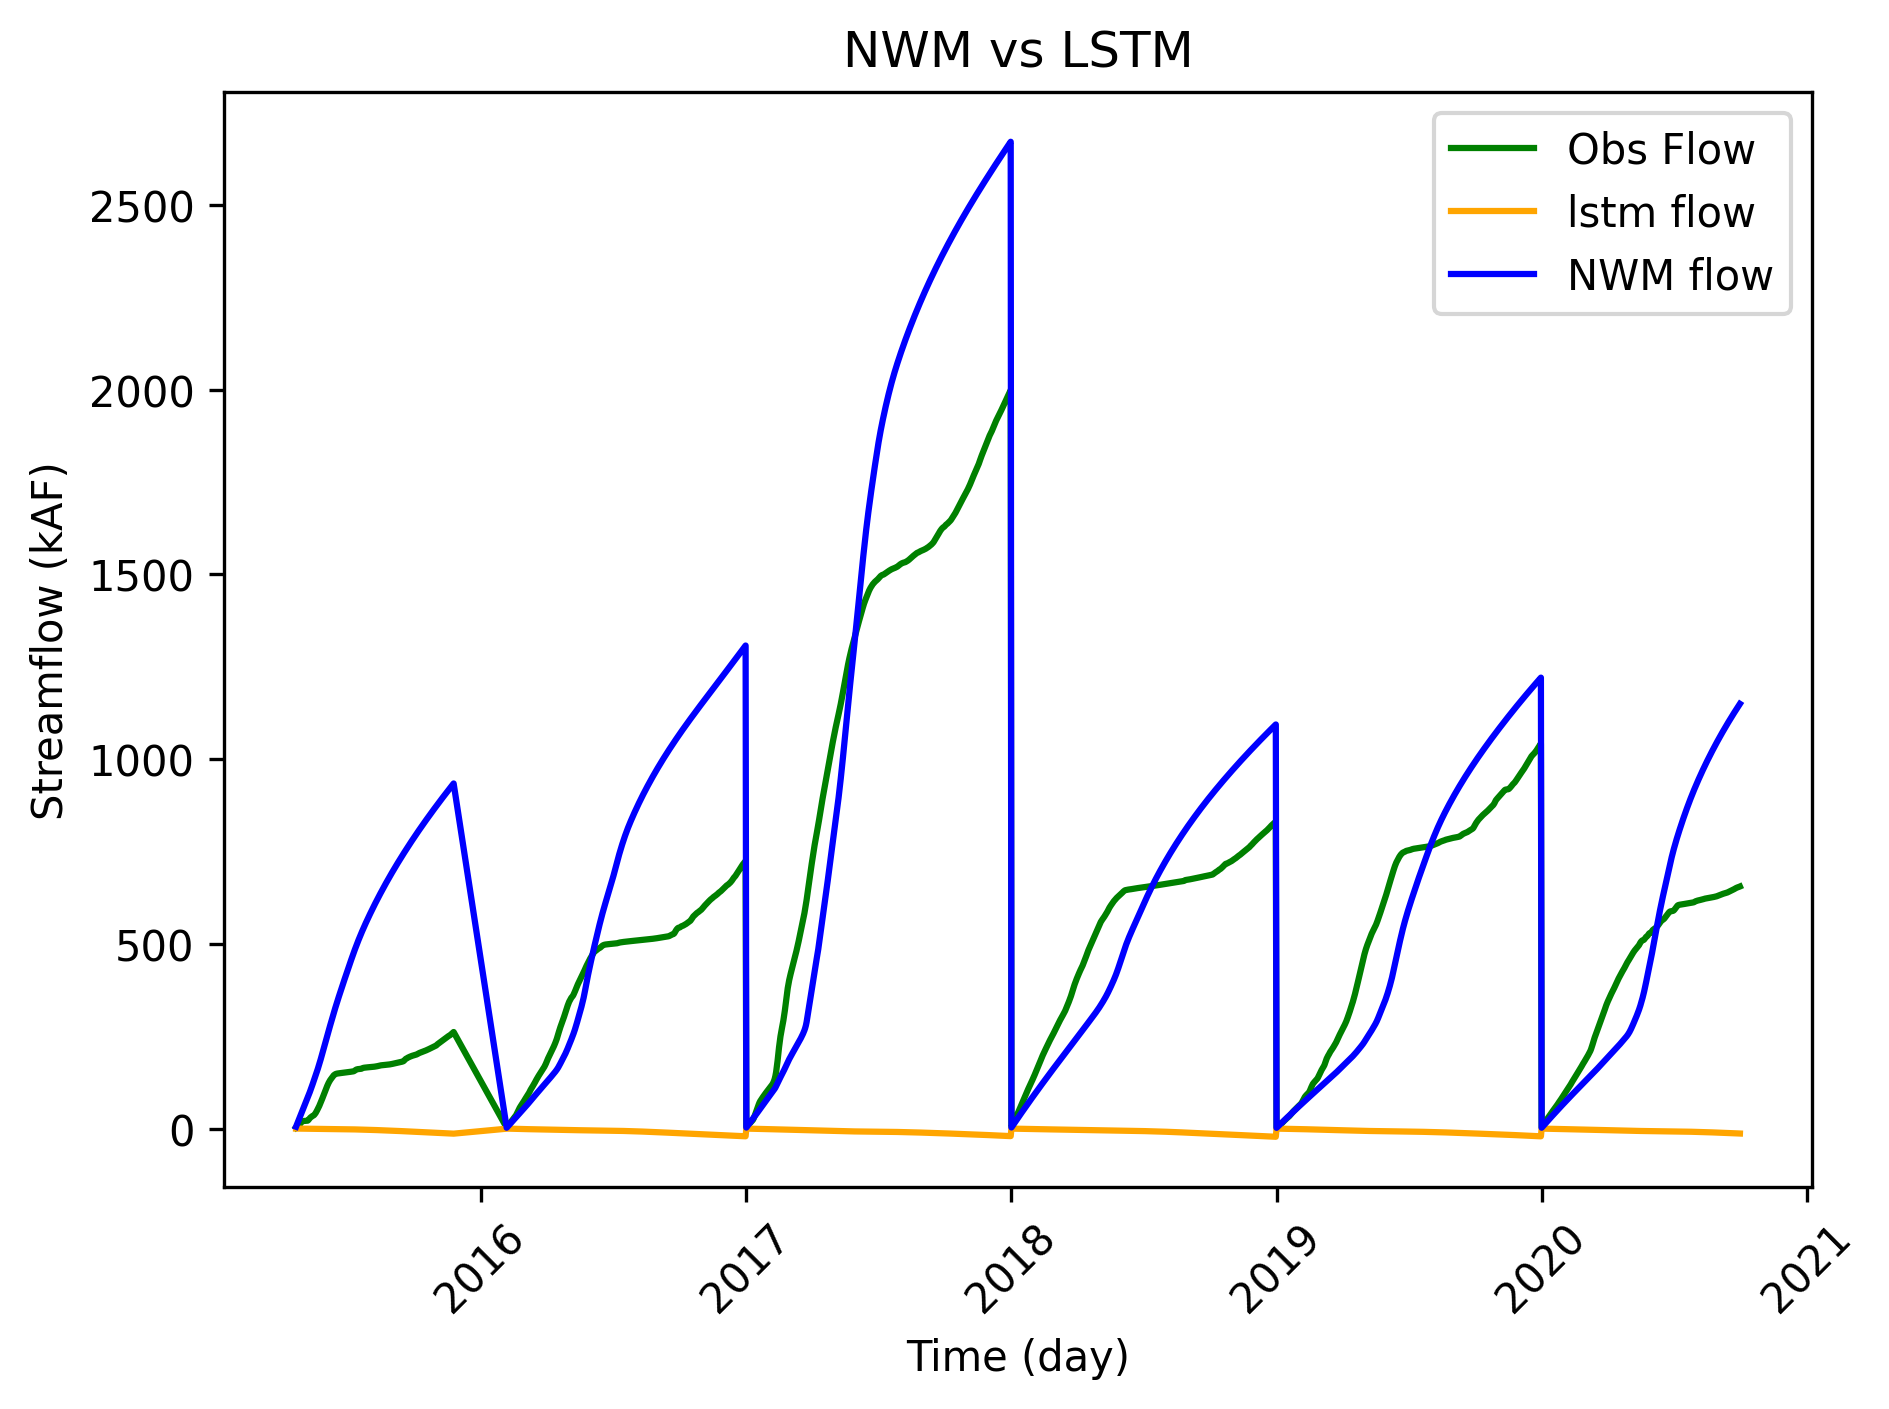

In [57]:
supply = True
EvalPlot(df_eval, supply)


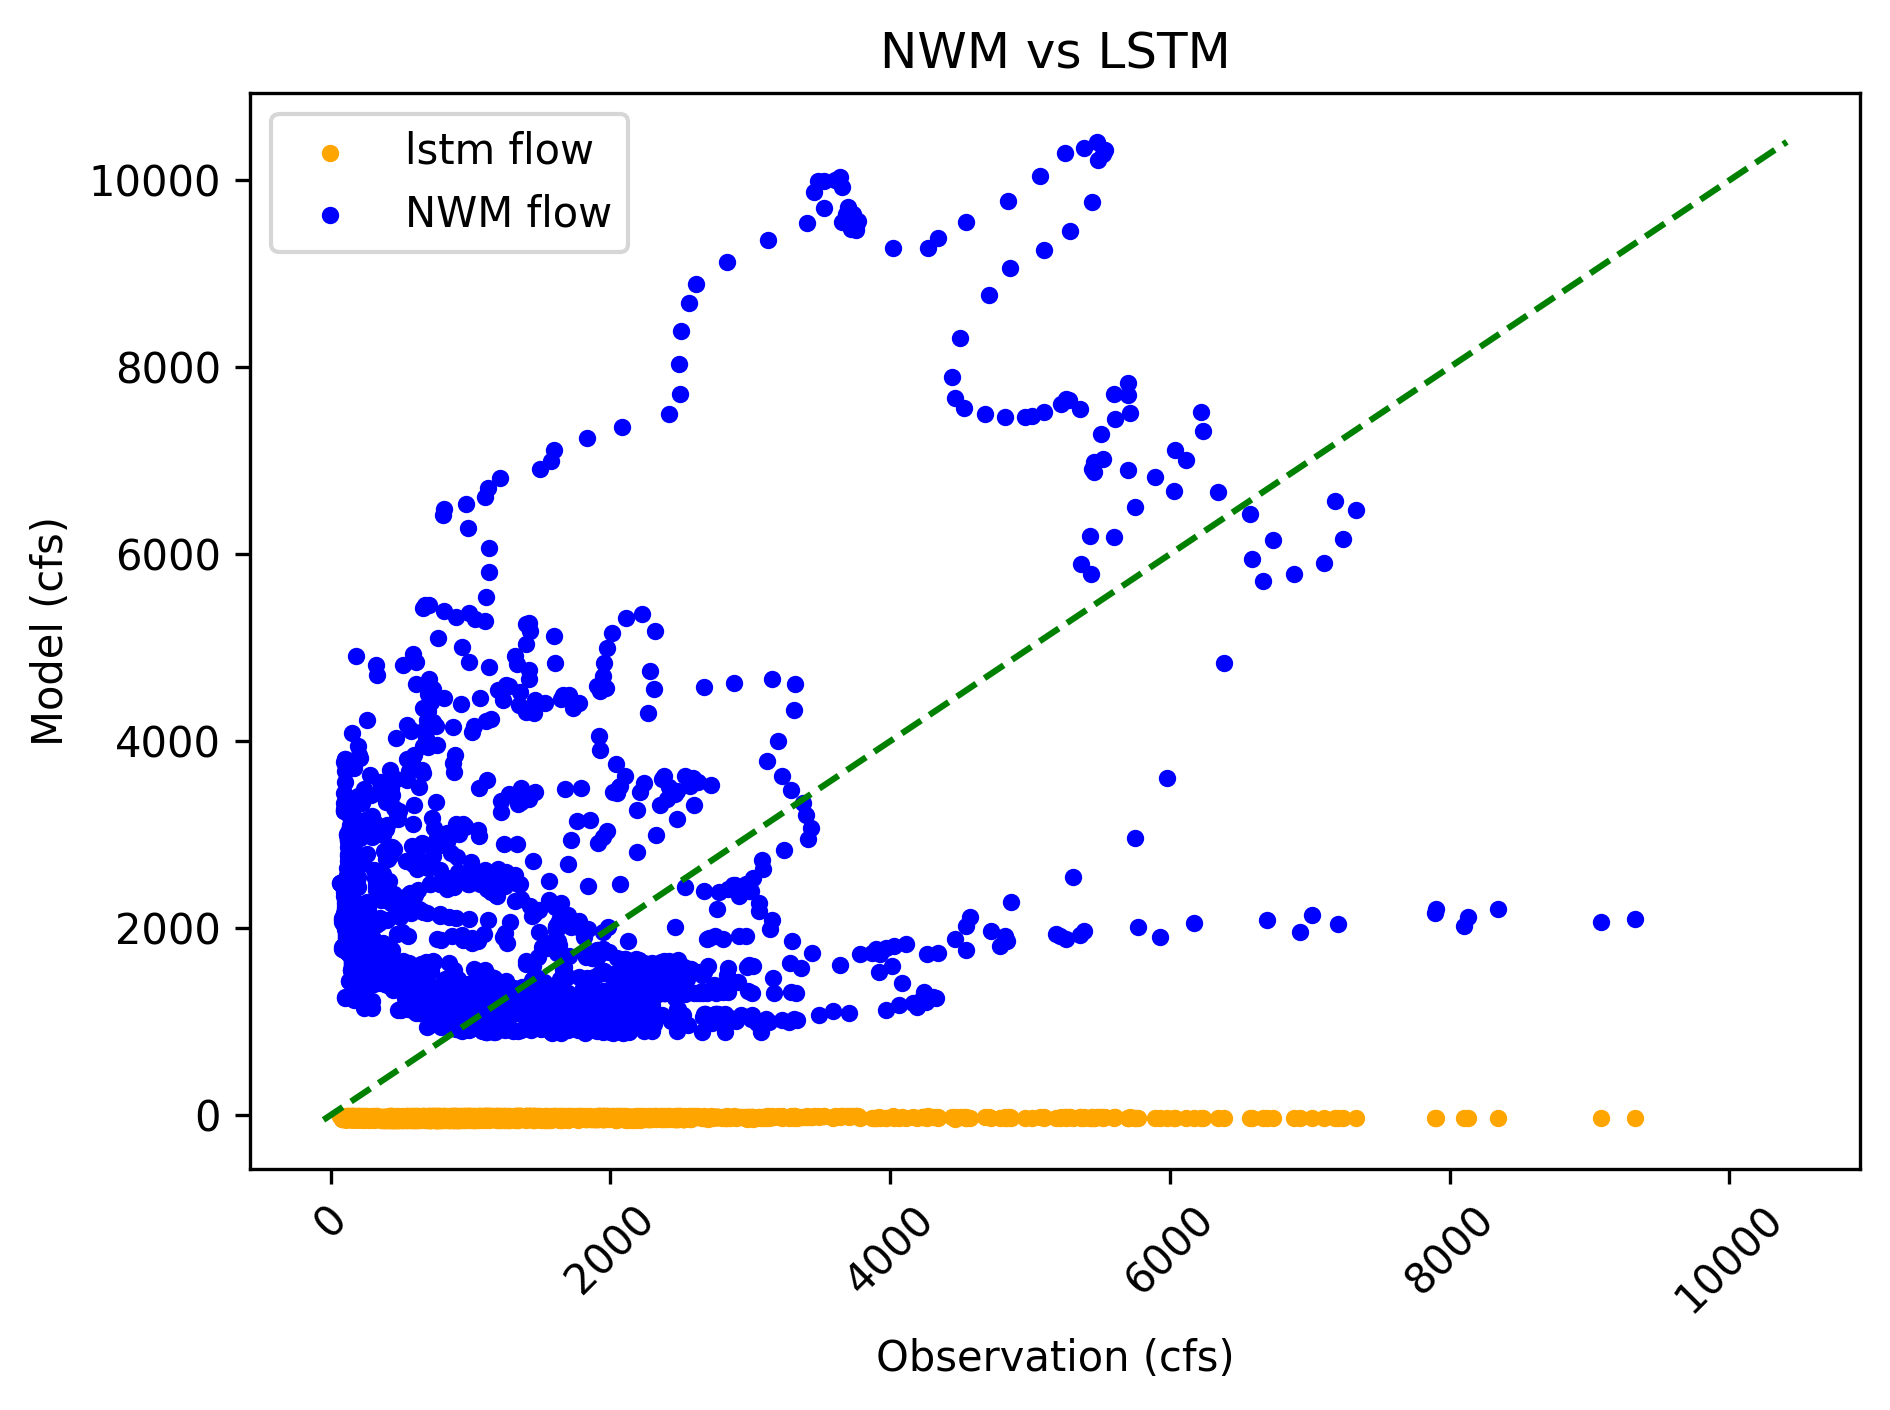

In [58]:
supply = False
EvalPlot(df_eval, supply)